In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('exchange_rate.csv')

In [3]:
df.shape

(7588, 2)

In [4]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [5]:
# Assume first column = Date, second column = Exchange Rate
date_col = df.columns[0]
val_col = df.columns[1]

In [6]:
# Parse date column and clean
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col])
df = df.sort_values(by=date_col).reset_index(drop=True)

In [7]:
# Set index
ts = df.set_index(date_col)[val_col].astype(float).dropna()


In [8]:
# Try to infer frequency
try:
    ts = ts.asfreq(pd.infer_freq(ts.index))
except:
    pass

In [9]:
len(ts)

7648

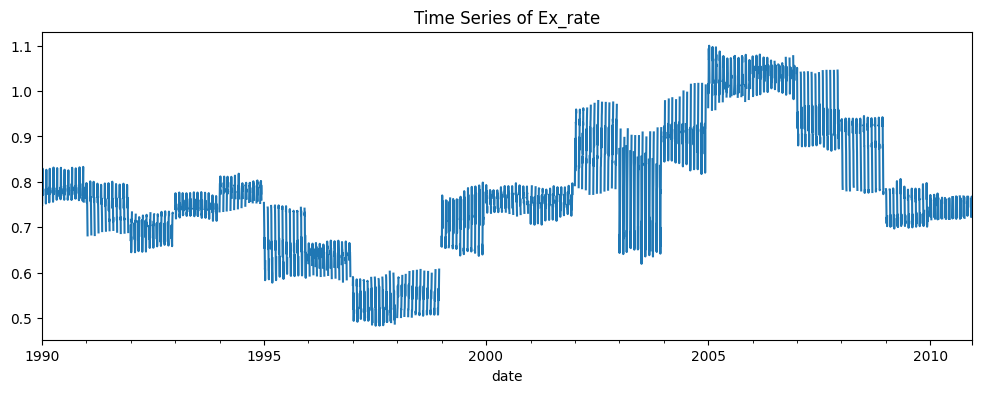

In [10]:
ts.plot(title=f"Time Series of {val_col}", figsize=(12,4))
plt.show()

In [11]:
# Check stationarity
adf_res = adfuller(ts.dropna())
print("ADF Statistic:", adf_res[0])
print("p-value:", adf_res[1])
if adf_res[1] < 0.05:
    print(" Series is stationary")
else:
    print(" Series may be non-stationary; differencing might be needed")

ADF Statistic: -1.5399319076838185
p-value: 0.5136733116580338
 Series may be non-stationary; differencing might be needed


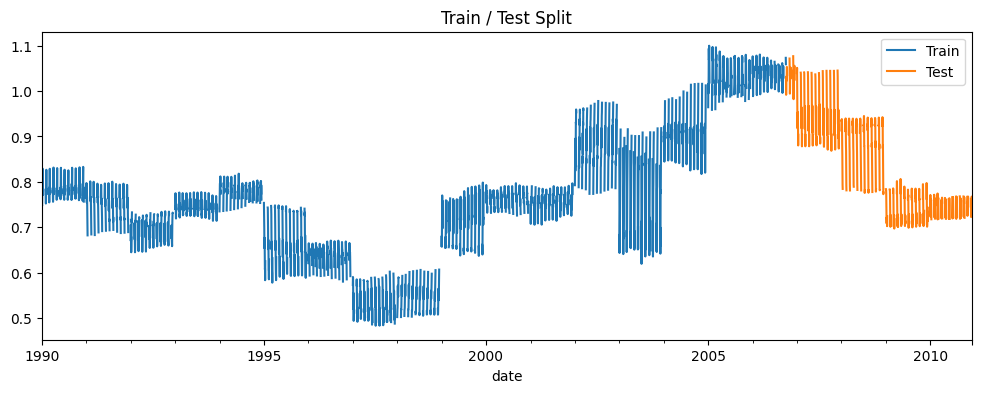

In [12]:
# 2. TRAIN / TEST SPLIT

test_size = int(0.2 * len(ts))
train, test = ts[:-test_size], ts[-test_size:]

plt.figure(figsize=(12,4))
train.plot(label='Train')
test.plot(label='Test')
plt.legend()
plt.title("Train / Test Split")
plt.show()


In [31]:
# 3. ARIMA PARAMETER SELECTION USING AIC

best_aic = np.inf
best_order = None
best_model = None

p_vals = range(0, 4)
d_vals = range(0, 3)
q_vals = range(0, 4)

for p in p_vals:
    for d in d_vals:
        for q in q_vals:
            try:
                model = ARIMA(train, order=(p,d,q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p,d,q)
                    best_model = model
            except:
                continue

print(f"\n Best ARIMA order: {best_order} with AIC = {best_aic}")

c:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 


 Best ARIMA order: (3, 1, 3) with AIC = -10194.237502861768


c:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


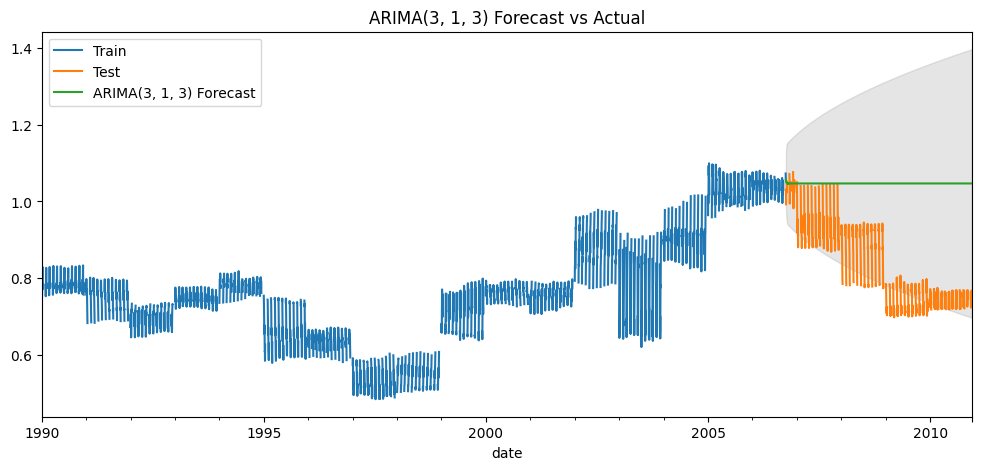

In [15]:
# 4. FIT ARIMA AND FORECAST

arima_model = ARIMA(train, order=best_order).fit()
n_forecast = len(test)
arima_forecast = arima_model.get_forecast(steps=n_forecast)
arima_pred = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()
plt.figure(figsize=(12,5))
train.plot(label='Train')
test.plot(label='Test')
arima_pred.index = test.index
arima_pred.plot(label=f'ARIMA{best_order} Forecast')
plt.fill_between(arima_ci.index,
                 arima_ci.iloc[:,0],
                 arima_ci.iloc[:,1],
                 color='gray', alpha=0.2)
plt.legend()
plt.title(f"ARIMA{best_order} Forecast vs Actual")
plt.show()

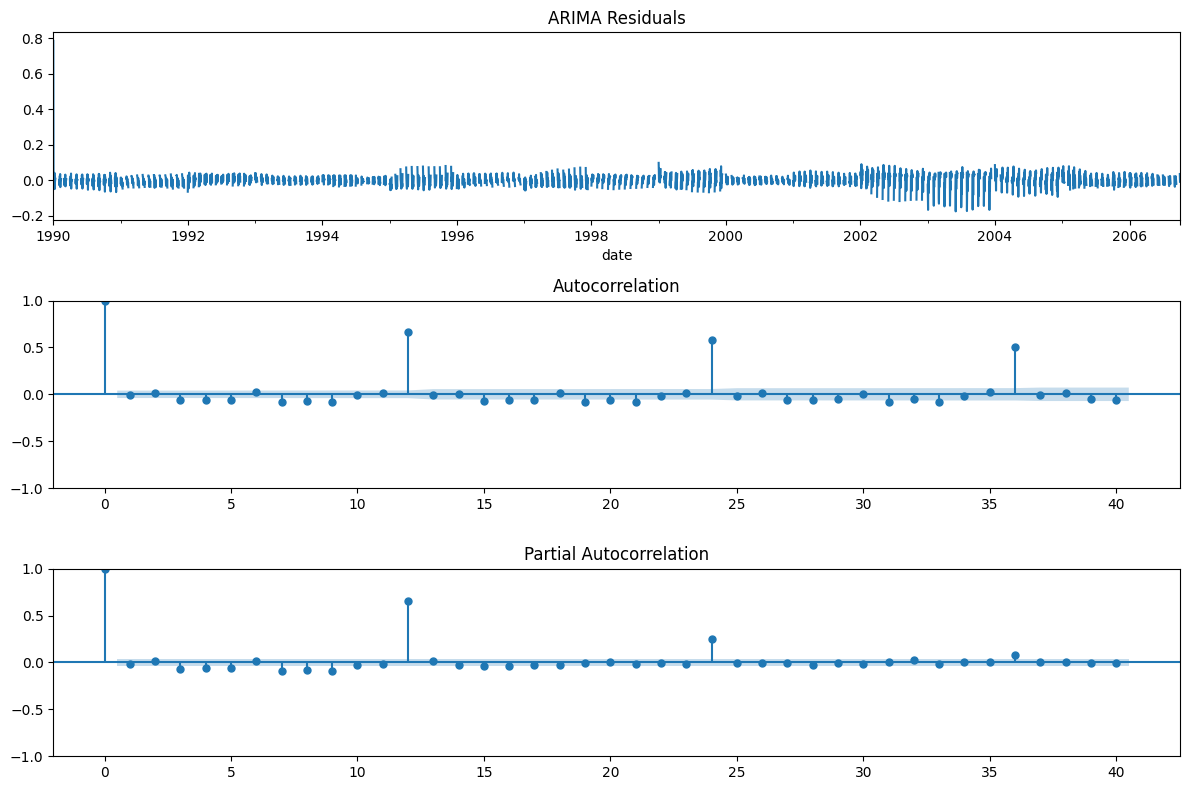

,lb_stat,lb_pvalue
10,73.363855,9.896017e-12


In [16]:
# 5. RESIDUAL DIAGNOSTICS
resid = arima_model.resid

plt.figure(figsize=(12,8))
plt.subplot(311)
resid.plot(title='ARIMA Residuals')
plt.subplot(312)
plot_acf(resid.dropna(), ax=plt.gca(), lags=40)
plt.subplot(313)
plot_pacf(resid.dropna(), ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(resid.dropna(), lags=[10], return_df=True)
lb_test

In [17]:
# 6. EXPONENTIAL SMOOTHING MODEL (HOLT-WINTERS)

import itertools
trend_opts = [None, 'add', 'mul']
seasonal_opts = [None, 'add', 'mul']

In [18]:
# Determine seasonal periods (if data length > 36, assume monthly seasonality)
seasonal_periods = 12 if len(ts) > 36 else None

best_es_aic = np.inf
best_es_model = None
best_es_params = None

In [19]:
for trend, seasonal_type in itertools.product(trend_opts, seasonal_opts):
    try:
        model = ExponentialSmoothing(train,
                                     trend=trend,
                                     seasonal=seasonal_type,
                                     seasonal_periods=seasonal_periods if seasonal_type else None,
                                     initialization_method='estimated').fit()
        aic = model.aic if hasattr(model, 'aic') else np.nan
        if np.isnan(aic):
            resid = model.resid
            sse = np.sum(resid**2)
            aic = sse + 2 * (1 if trend else 0) + 2 * (1 if seasonal_type else 0)
        if aic < best_es_aic:
            best_es_aic = aic
            best_es_model = model
            best_es_params = (trend, seasonal_type)
    except:
        continue

print(f"\n Best Exponential Smoothing params: {best_es_params} with AIC ≈ {best_es_aic}")


 Best Exponential Smoothing params: (None, None) with AIC ≈ 0.007708941337919996


c:\Anaconda\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Anaconda\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


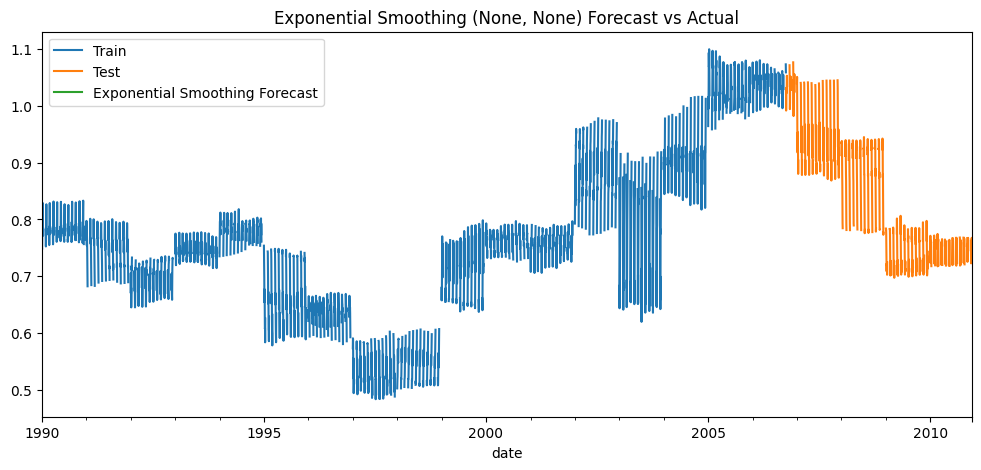

In [20]:
# 7. EXPONENTIAL SMOOTHING FORECAST

if best_es_model:
    es_forecast = best_es_model.forecast(steps=len(test))
    es_forecast.index = test.index

    plt.figure(figsize=(12,5))
    train.plot(label='Train')
    test.plot(label='Test')
    es_forecast.plot(label='Exponential Smoothing Forecast')
    plt.legend()
    plt.title(f"Exponential Smoothing {best_es_params} Forecast vs Actual")
    plt.show()
else:
    print(" No Exponential Smoothing model could be fit.")

In [21]:
# 8. EVALUATION METRICS (MAE, RMSE, MAPE)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [22]:
arima_pred = arima_pred.reindex(test.index).astype(float)
es_pred = es_forecast.reindex(test.index).astype(float) if best_es_model is not None else None

In [23]:
# Ensure predictions and test data align and contain no NaN
arima_pred = arima_pred.dropna()
test_aligned = test.loc[arima_pred.index].dropna()

# Filter both to matching indices
common_idx = test_aligned.index.intersection(arima_pred.index)
test_aligned = test_aligned.loc[common_idx]
arima_pred = arima_pred.loc[common_idx]


In [24]:
if es_pred is not None:
    es_pred = es_pred.dropna()
    common_idx_es = test.index.intersection(es_pred.index)
    es_pred = es_pred.loc[common_idx_es]
    test_es = test.loc[common_idx_es]


In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define MAPE safely
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = (y_true != 0) & (~np.isnan(y_true)) & (~np.isnan(y_pred))
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [26]:
# --- ALIGN & DROP EMPTY/UNMATCHED INDEXES ---
if 'es_pred' in locals():
    test_es, es_pred = test.align(es_pred, join='inner')
    test_es = test_es.dropna()
    es_pred = es_pred.loc[test_es.index]
else:
    test_es = pd.Series(dtype=float)
    es_pred = pd.Series(dtype=float)

test_aligned, arima_pred = test.align(arima_pred, join='inner')
test_aligned = test_aligned.dropna()
arima_pred = arima_pred.loc[test_aligned.index]

In [27]:
# --- SAFETY CHECKS ---
if len(test_aligned) == 0 or len(arima_pred) == 0:
    print(" ARIMA test or prediction data is empty after alignment.")
if len(test_es) == 0 or len(es_pred) == 0:
    print(" Exponential Smoothing test or prediction data is empty after alignment.")

 Exponential Smoothing test or prediction data is empty after alignment.


In [28]:
# --- RESULTS CALCULATION ---
results = {}

if len(test_aligned) > 0:
    results['ARIMA'] = {
        'MAE': mean_absolute_error(test_aligned, arima_pred),
        'RMSE': np.sqrt(mean_squared_error(test_aligned, arima_pred)),
        'MAPE': mape(test_aligned.values, arima_pred.values)
    }

In [29]:
if len(test_es) > 0:
    results['ExponentialSmoothing'] = {
        'MAE': mean_absolute_error(test_es, es_pred),
        'RMSE': np.sqrt(mean_squared_error(test_es, es_pred)),
        'MAPE': mape(test_es.values, es_pred.values)
    }

In [30]:
# Display Results
if results:
    print("\n=== MODEL PERFORMANCE METRICS ===")
    print(pd.DataFrame(results).T.round(4))
else:
    print(" No valid evaluation data found for either model.")


=== MODEL PERFORMANCE METRICS ===
          MAE    RMSE     MAPE
ARIMA  0.2042  0.2297  26.1343


## Model Comparison — Advantages & Limitations

### ARIMA (Autoregressive Integrated Moving Average):

Advantages: Captures autoregressive and moving-average structures, flexible for non-seasonal and seasonal (SARIMA) patterns, strong theory for inference and diagnostics. Works well when the series is primarily driven by its own past values.

Limitations: Needs stationarity (may require differencing), can be sensitive to model specification, can struggle with multiple seasonalities or complex trend/seasonal interactions.

Exponential Smoothing (Holt-Winters):

Advantages: Handles level, trend, and seasonality naturally; often simpler to tune; tends to perform well for data with clear trend and seasonality and when recent observations are more informative.

Limitations: Less interpretable in terms of autocorrelation structure; may not capture complex ARMA-like dynamics; seasonal_periods must be known.

Which to prefer:

If the data shows clear seasonal patterns and trend, Holt-Winters often performs competitively.

If the residuals or ACF/PACF indicate ARMA structure or if you need detailed diagnostic inference, ARIMA/SARIMA is preferred.

Use the test-set error metrics to objectively choose the better model for the dataset.

Diagnostics Checklist

Residual mean ≈ 0.

Residuals show no significant autocorrelation (ACF, Ljung–Box).

Residual variance stable (no heteroskedastic structures left).

Forecast confidence intervals behave sensibly (cover most actuals).

Evaluation metrics computed on properly aligned, NaN-free test-prediction pairs.